In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import ttest_ind
import seaborn as sns
from statsmodels.stats.anova import anova_lm

In [2]:
data_all_years = pd.read_csv('data_all.csv', sep = ',')
data_all_years = data_all_years.drop(data_all_years.index[569])
data_all_years = data_all_years.drop(data_all_years.index[569])

In [3]:
predictors = ["exit_velocity_avg", "launch_angle_avg" ,"sweet_spot_percent", "barrels", "barrel_batted_rate", "solidcontact_percent", "flareburner_percent", "poorlyunder_percent", "poorlytopped_percent", "poorlyweak_percent", "hard_hit_percent", "z_swing_percent", "z_swing_miss_percent", "oz_swing_percent", "oz_swing_miss_percent", "oz_contact_percent", "out_zone_swing_miss", "out_zone_swing", "out_zone_percent", "out_zone", "meatball_swing_percent", "meatball_percent", "pitch_count_offspeed", "pitch_count_fastball", "pitch_count_breaking", "pitch_count", "iz_contact_percent", "in_zone_swing_miss", "in_zone_swing", "in_zone_percent", "in_zone", "edge_percent", "edge", "whiff_percent", "swing_percent", "pull_percent", "straightaway_percent", "opposite_percent", "batted_ball", "f_strike_percent", "groundballs_percent", "groundballs", "flyballs_percent", "flyballs", "linedrives_percent", "linedrives", "popups_percent", "popups", "n_bolts","sprint_speed"]

<ipython-input-4-37e0afabcbe7>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


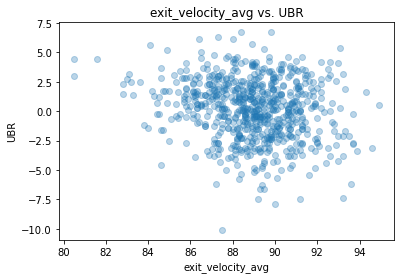

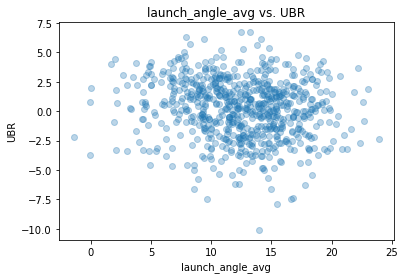

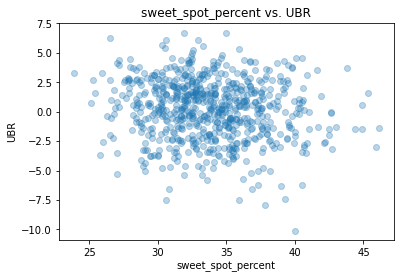

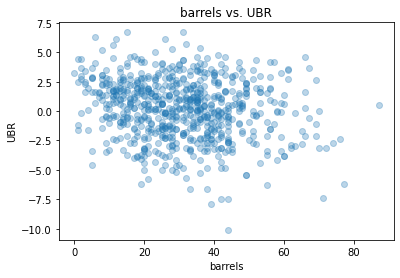

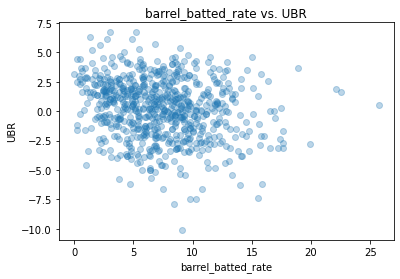

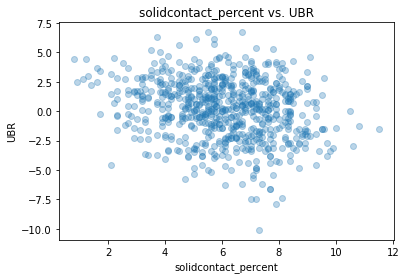

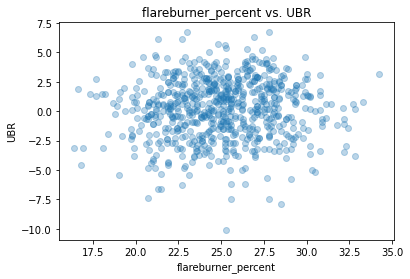

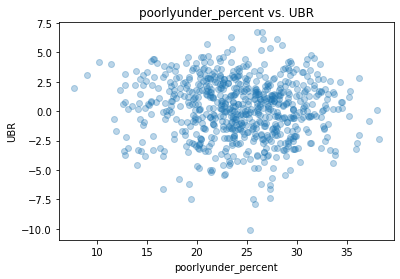

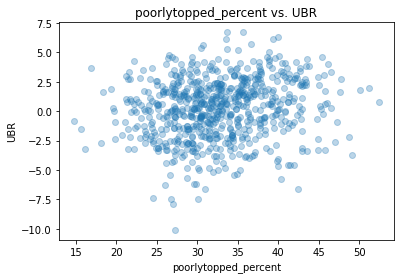

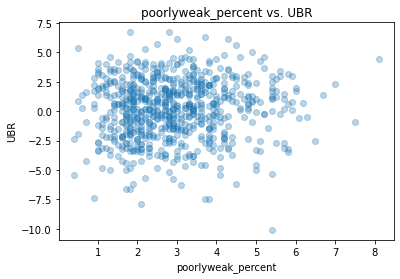

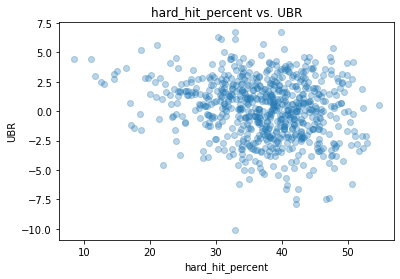

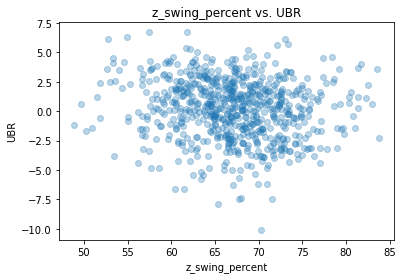

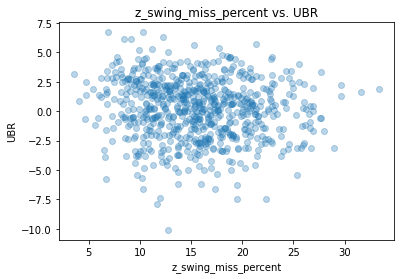

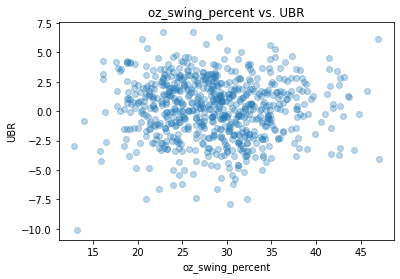

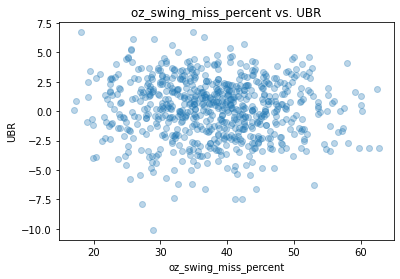

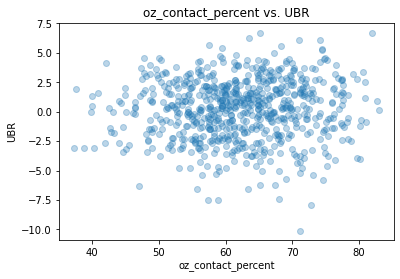

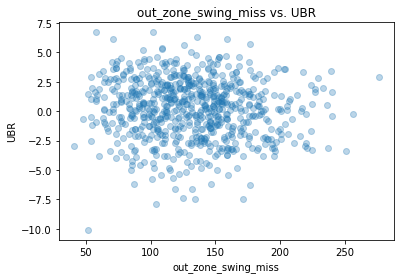

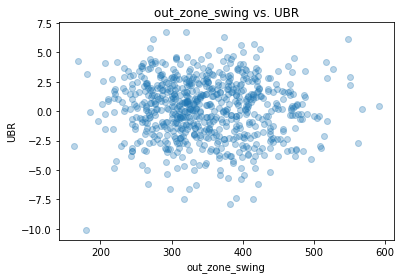

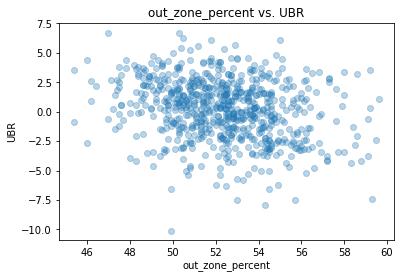

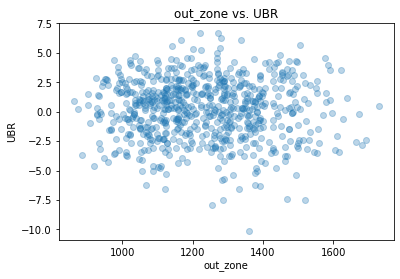

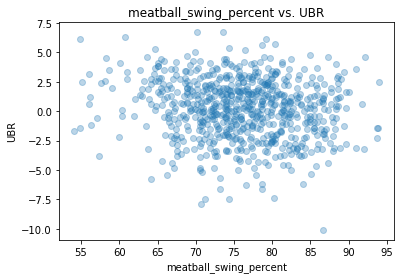

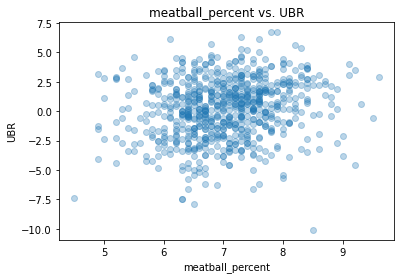

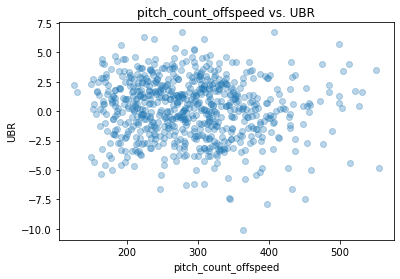

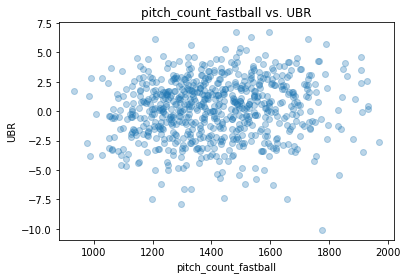

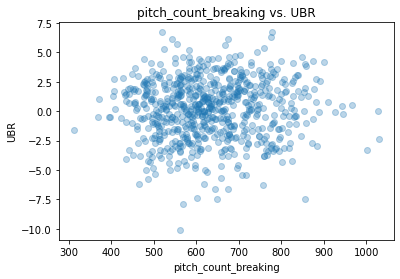

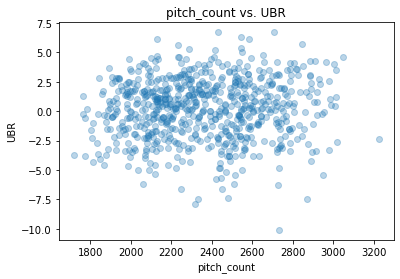

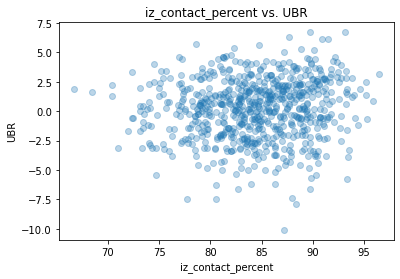

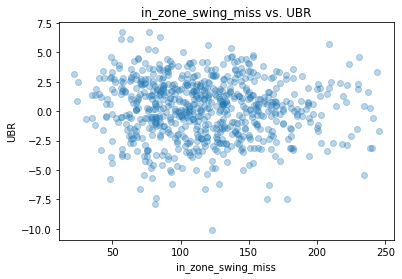

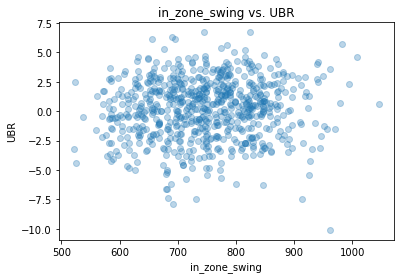

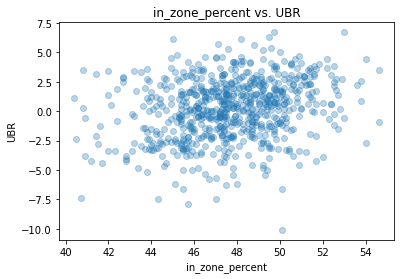

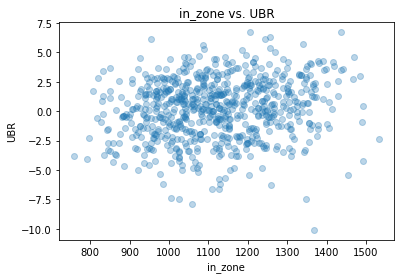

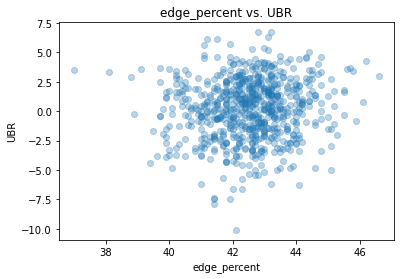

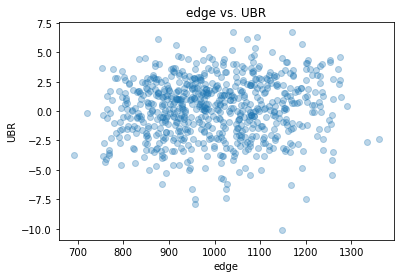

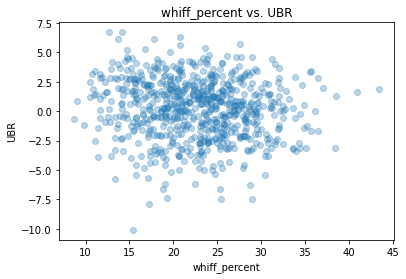

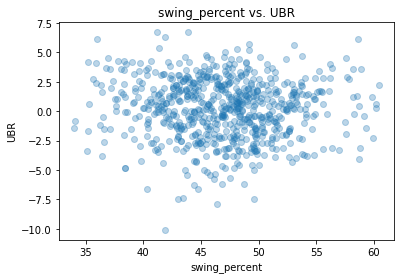

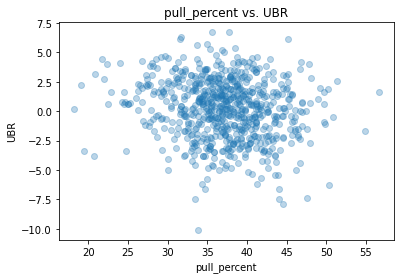

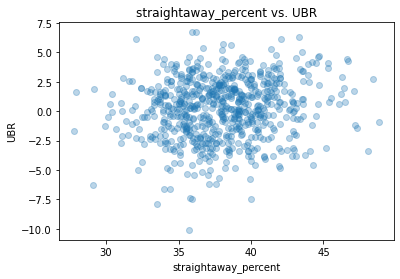

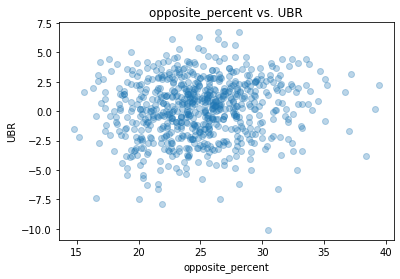

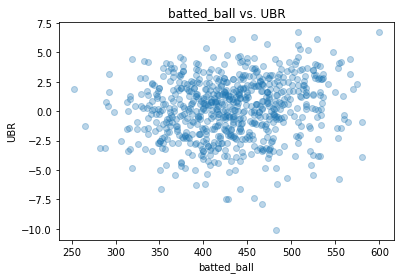

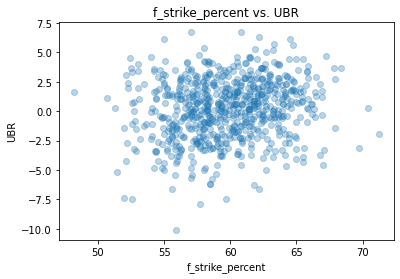

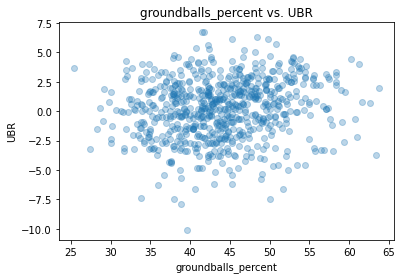

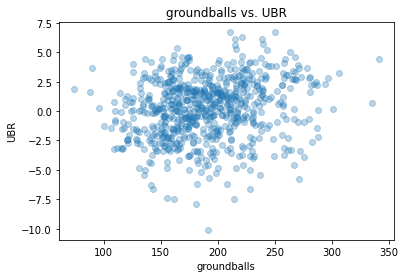

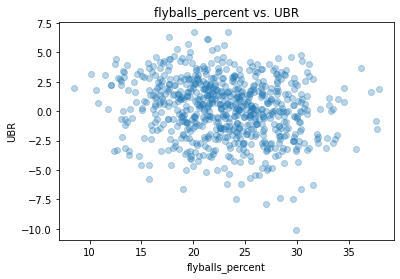

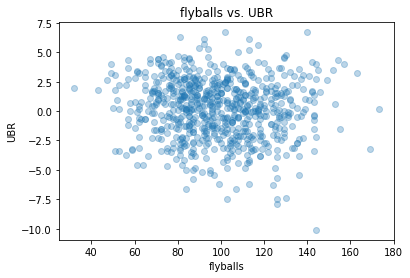

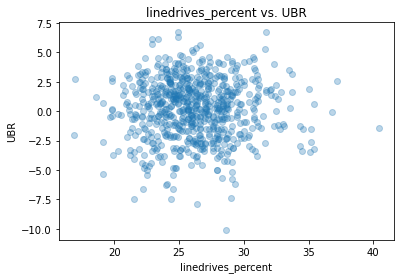

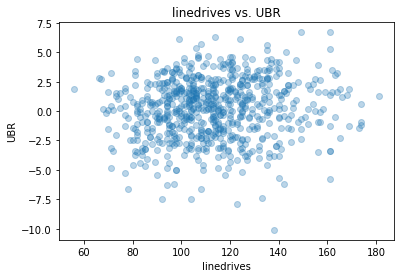

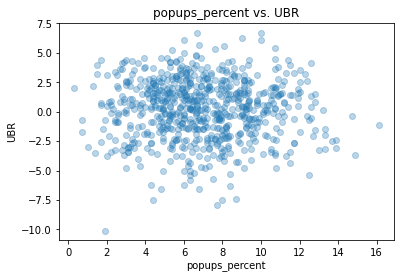

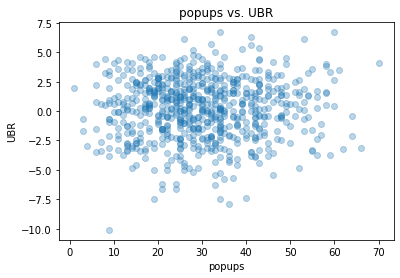

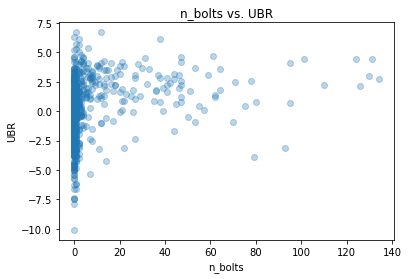

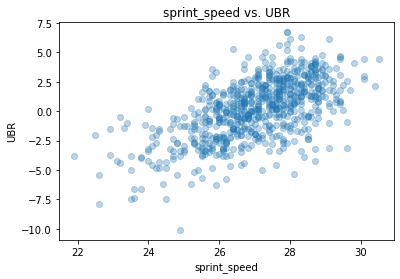

In [4]:
i = 0
for x in predictors:
  plt.figure(i)
  plt.scatter(data_all_years[x], data_all_years['UBR'],alpha = 0.3)
  plt.xlabel(x)
  plt.ylabel('UBR')
  plt.title(x + ' vs. UBR')
  i = i + 1

In [5]:
X = np.array(data_all_years[["exit_velocity_avg","barrels","solidcontact_percent","in_zone_percent","n_bolts","sprint_speed"]])

In [6]:
import statsmodels.api as sm

In [7]:
ubr_model = sm.OLS(data_all_years['UBR'],X)
ubr_model_results = ubr_model.fit()
print(ubr_model_results.pvalues)

x1    4.834052e-35
x2    1.140136e-01
x3    8.090202e-01
x4    5.119001e-01
x5    2.173755e-02
x6    2.154374e-48
dtype: float64


Based on the above p - value output, it seems that there are a few insignificant predictors(based off of a minimal significance p-value threshold of 0.05 or below). These insignificant predictors are:

barrels(with p-value = 0.1140)

solidcontact_percent(with p-value = 0.8090)

in_zone_percent(with p-value = 0.5119)


In [8]:
# Make a reduced model without the above predictors

ubr_preds_red = np.array(data_all_years[["exit_velocity_avg","n_bolts","sprint_speed"]])

ubr_model_red = sm.OLS(data_all_years['UBR'],ubr_preds_red)
ubr_model_red_results = ubr_model_red.fit()

In [9]:
# Running the anova model to test whether it is ok to remove this predictor

anovatest = anova_lm(ubr_model_red_results, ubr_model_results)
print(anovatest)

   df_resid          ssr  df_diff    ss_diff         F    Pr(>F)
0     701.0  2980.968790      0.0        NaN       NaN       NaN
1     698.0  2965.244435      3.0  15.724355  1.233805  0.296425


/Users/jonasmilano/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Since the above output yields a p-vlaue above our threshold of 0.05, we will remove the insignificant predictors "barrels","solidcontact_percent",and "in_zone_percent" as these are not adding anything to the full model.

Final basic Model:

UBR ~ exit_velocity_avg + n_bolts + sprint_speed

In [10]:
# Start of the polynomial model process

data_all_mod_ubr = data_all_years.copy()

data_all_mod_ubr["exit_velocity_avg^2"] = data_all_mod_ubr["exit_velocity_avg"] * data_all_mod_ubr["exit_velocity_avg"]

data_all_mod_ubr["n_bolts^2"] = data_all_mod_ubr["n_bolts"] * data_all_mod_ubr["n_bolts"]

data_all_mod_ubr["sprint_speed^2"] = data_all_mod_ubr["sprint_speed"] * data_all_mod_ubr["sprint_speed"]

data_all_mod_ubr["exit_velocity_avg^3"] = data_all_mod_ubr["exit_velocity_avg"] * data_all_mod_ubr["exit_velocity_avg"] * data_all_mod_ubr["exit_velocity_avg"]

X_2_ubr = np.array(data_all_mod_ubr[["exit_velocity_avg","n_bolts","sprint_speed", "exit_velocity_avg^2", "n_bolts^2","sprint_speed^2" ]])


ubr_poly = sm.OLS(data_all_mod_ubr['UBR'],X_2_ubr)
ubr_poly = ubr_poly.fit()

print(ubr_poly.pvalues)


x1    0.068073
x2    0.305050
x3    0.190941
x4    0.099599
x5    0.885683
x6    0.517438
dtype: float64


In [11]:
# It seems that adding quadratic terms made the model significantly less significant so we will see if we can remove them all via an anova test and compare this model to the original.

X_2_ubr_red = np.array(data_all_mod_ubr[["exit_velocity_avg","n_bolts","sprint_speed"]])


ubr_poly_red = sm.OLS(data_all_mod_ubr['UBR'],X_2_ubr_red)
ubr_poly_red = ubr_poly_red.fit()

anovatest = anova_lm(ubr_poly_red, ubr_poly)
print(anovatest)

   df_resid          ssr  df_diff     ss_diff          F        Pr(>F)
0     701.0  2980.968790      0.0         NaN        NaN           NaN
1     698.0  2830.273753      3.0  150.695037  12.388099  6.680448e-08


/Users/jonasmilano/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [12]:
# It appears that at least one of the polynomial terms is significant so we will have to remove them one by one until we get a significant set of predictors. We will first try a quadratic model without sprint_speed^2

X_3_ubr = np.array(data_all_mod_ubr[["exit_velocity_avg","n_bolts","sprint_speed", "exit_velocity_avg^2", "n_bolts^2"]])


ubr_poly_2 = sm.OLS(data_all_mod_ubr['UBR'],X_3_ubr)
ubr_poly_2 = ubr_poly_2.fit()

print(ubr_poly_2.pvalues)


x1    1.293512e-24
x2    1.348340e-01
x3    8.542647e-57
x4    3.060056e-09
x5    7.575374e-01
dtype: float64


In [13]:
# From the p-value output it seems like n_bolt's quadratic term is insignificant so we will confirm its removal by creating a reduced model and comparing the above model to it and see if there is a significant difference

X_3_ubr_red = np.array(data_all_mod_ubr[["exit_velocity_avg","n_bolts","sprint_speed", "exit_velocity_avg^2"]])


ubr_poly_3 = sm.OLS(data_all_mod_ubr['UBR'],X_3_ubr_red)
ubr_poly_3 = ubr_poly_3.fit()


anovatest = anova_lm(ubr_poly_3, ubr_poly_2)
print(anovatest)

   df_resid          ssr  df_diff  ss_diff        F    Pr(>F)
0     700.0  2832.360874      0.0      NaN      NaN       NaN
1     699.0  2831.974443      1.0  0.38643  0.09538  0.757537


/Users/jonasmilano/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [14]:
# As shown above, it is clear that the quadratic term for n_bolts is not adding to the model and we can remove it. Now we have a significant model with one quadratic term. Lets try adding a cubic term to see if we can increase the significance.

X_4_ubr = np.array(data_all_mod_ubr[["exit_velocity_avg","n_bolts","sprint_speed", "exit_velocity_avg^2","exit_velocity_avg^3"]])


ubr_poly_4 = sm.OLS(data_all_mod_ubr['UBR'],X_4_ubr)
ubr_poly_4 = ubr_poly_4.fit()

print(ubr_poly_4.pvalues)



x1    8.181219e-01
x2    3.652533e-03
x3    2.216776e-61
x4    7.966385e-01
x5    6.956497e-01
dtype: float64


In [15]:
# As seen above, it seems that the addition of the cubic term decreased the significance of the model overall and we will check this with an anova test.

anovatest = anova_lm(ubr_poly_3, ubr_poly_4)
print(anovatest)


   df_resid          ssr  df_diff   ss_diff         F   Pr(>F)
0     700.0  2832.360874      0.0       NaN       NaN      NaN
1     699.0  2831.740389      1.0  0.620485  0.153163  0.69565


/Users/jonasmilano/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [16]:
# Therefore, since the p-value of the above output is so high, we can conclude that the cubic term does not add anything to the model overall and we are left with the final 4 predictor quadratic model:

ubr_poly_3

In [17]:
# UBR Model Residuals Process

data_all_ubr = data_all_mod_ubr[["exit_velocity_avg","n_bolts","sprint_speed", "exit_velocity_avg^2"]]

# Create the design matrix of all X values

ubr_design_matrix = np.zeros([len(data_all_mod_ubr),4])
for x in range(0,len(data_all_mod_ubr)):
    ubr_design_matrix[x] = np.array(data_all_ubr.iloc[x])
    
# Get Fitted Values
ubr_fitted = ubr_poly_3.predict(ubr_design_matrix)



# Get Actual UBR values of each player from data
ubr_actual = np.array(data_all_mod_ubr['UBR'])


# Calculate Residuals
ubr_resids = ubr_fitted - ubr_actual


# Residuals Matrix

ubr_residssq = np.zeros(len(ubr_resids))
for x in range(0,len(ubr_residssq)):
    ubr_residssq[x] = ubr_resids[x]*ubr_resids[x]

ubr_residssq



array([5.61958598e-01, 2.41111597e+01, 2.72764781e+00, 6.54945810e+00,
       2.15097249e+00, 1.33351734e+01, 1.41865963e+00, 3.01582761e+00,
       3.39571079e+01, 2.55846193e+00, 7.74657814e+00, 3.76039483e+00,
       6.40651624e-02, 5.80511340e-01, 1.65242618e+00, 1.64826698e+00,
       2.01252379e-04, 7.91469308e+00, 1.79721265e+00, 2.85448661e+00,
       1.12879420e+00, 5.05174709e-01, 4.63999186e+00, 1.03721665e+00,
       5.86922841e-01, 2.94126129e-02, 2.49406645e+00, 2.20706008e-01,
       2.85468101e-01, 8.25597623e+00, 8.80169346e-01, 4.09825956e+00,
       2.59021670e+00, 7.89966718e+00, 2.44158679e+00, 1.79110077e+00,
       1.59830930e+01, 7.99767189e-02, 5.68776862e+00, 6.54827304e+00,
       3.21657775e+00, 7.06208973e-02, 6.57982773e+00, 3.31328545e+00,
       2.02136283e+00, 5.54023989e+00, 1.72039596e+01, 1.98973768e+01,
       3.52299678e+00, 2.81467089e+00, 3.03642985e+01, 8.95503672e-02,
       6.28892256e+00, 1.47858082e+00, 2.16225973e-02, 3.96664218e+00,
      

### Interpretations/Conclusions


Although there is a possibility that the model could be underfitted, from the scatterplots alone, this is probabaly not the case. 

When building the model we looked at the scatterplots and added predictors based on whethern we saw some sort of pattern(either negative or positive) in the plot. Therefore, we ended up adding a total of 6 predictors to the original model based on the patterns we saw in the plots.

 However, after running the appropriate tests for significance and ensuring the predictors were all significant, we ended up eliminating 3 of the 6 predictors and only keeping "exit_velocity" , "n_bolts" , and "sprint_speed" which coincidentally were also the only predictors with very strong association to UBR in the plots. Therefore, the other predictors that were discarded resembled some sort of positive/negative asssociation in the graph, however the fact that there was any subtlty rendered these predictors insignificant, therefore we feel that this is an accurate model depicting UBR as it includes the predictors that influence it the most.

Based on the results, it is apparent that UBR is heavily influenced by the two other base running statistics which are n_bolts(), and sprint_speed(measurinf how fast the player runs). This was no surprise and was a welcomed sight as we would expect running stats to associate strongly with a base running statistic such as UBR, further reaffirming the model's strength. However, we were surprised by the significance of the exit_velocity_avg stat on UBR. Initially, it may not seem that the ball's exit velocity off of a player's bat has significance, but considering many balls that are hit with a high velocity are line drives, or homeruns it is not totally impossible to think that players with high exit velocities will be pressured to cover more bases and run faster to get as close to home as possible, so it is validly significant.

Therefore, we have our significant control predictors of sprint_speed and n_bolts to ensure the model is correct, but we were alsos surprised and interested in the fact that higher exit velocities might also impact UBR in a positive way as player who get harder hits may end up collecting more bases with their speed. 

### Limitations

One of the biggest limitations(and this applies for all the models) is that we are basing the potential significance of the predictors on what we see from the scatterplots. An example of how this can be problematic is by the addition of n_bolts to the UBR model. From the plot, it is really hard to tell whether or not n_bolts would be a significant predictor, however due to the fact that it is a base running statistic, we ended up adding it into the model due to intuition, as it turns out it was quite a significant predictor. Therefore, if we were to add/not add predictors to the model based solely on the scatterplots we may end up leaving out some key predictors, or create more work for ourselves by needing to remove insignificant predictors from the model which looked good in the plots. Therefore, we may be able to get a better understanding of significance of each predictor by runnig all of them through some sort of model building procedure that evaluates each facet of the predictors relation to the response variable and comes out wuth a comprehensive list of what predictors are/arent contributing to the response.

We could be missing some predictors/stats which could better explain UBR that are either not in the data_all dataset or not in the model becuase they did not look significant from the scatterplots(see above). Moreover, we did not check for the possibility of greater significance by the addition of polynomial terms or check for interaction terms, which could help in creating a stronger, more precise model.

Lastly, UBR is also an arbitrary value determined by a specific set of events which grant positive increases/negative increases in the point value of UBR. Therefore, the values of the predictors and UBR have different contexts which could create some limitations and restraint when further evaluating the relationship between UBR and the predictors.






In [18]:
# UBR Model Residuals Process

data_all_ubr = data_all_mod_ubr[["exit_velocity_avg","n_bolts","sprint_speed", "exit_velocity_avg^2"]]

In [19]:
ubr_design_matrix = np.zeros([len(data_all_mod_ubr),4])
for x in range(0,len(data_all_mod_ubr)):
    ubr_design_matrix[x] = np.array(data_all_ubr.iloc[x])

In [20]:
ubr_fitted = ubr_poly_3.predict(ubr_design_matrix)
ubr_fitted

array([-1.44963898e+00,  1.01031157e+00,  1.04844079e+00, -9.59190908e-01,
        1.33338059e+00, -1.65173568e+00, -2.08925012e-01, -1.53661383e+00,
       -5.27272770e-01,  1.90048072e+00,  1.48326753e+00,  1.76082625e+00,
       -9.53110969e-01,  3.38087052e-01, -1.11453270e+00,  2.01615150e+00,
        2.68581366e+00, -3.78669357e+00,  1.64060160e+00, -1.89522598e-01,
       -1.23755273e+00, -3.41075643e+00,  1.44593597e+00, -1.18438336e-01,
       -2.63389110e+00,  7.15010579e-02, -3.20738638e-01,  1.06979358e+00,
       -6.34292149e-01,  1.32667854e+00, -3.81734093e-02, -3.24415857e-01,
       -1.09415019e-01, -9.89365342e-01, -1.37442228e-01,  1.96167987e+00,
       -3.97886063e-01,  1.31719845e+00, -2.08490432e+00,  1.84104063e+00,
        2.30651798e+00, -1.96574593e+00,  1.13488251e+00, -1.47975676e+00,
       -2.37825360e+00, -9.53771419e-01,  2.04776561e+00,  2.06064757e+00,
       -1.37696478e+00,  6.22301906e-01,  2.41038098e+00,  1.70075033e+00,
        7.07772429e-01,  

In [21]:
ubr_actual = np.array(data_all_mod_ubr['UBR'])
ubr_actual

array([ -0.7,  -3.9,   2.7,   1.6,   2.8,   2. ,  -1.4,   0.2,   5.3,
         3.5,  -1.3,   3.7,  -0.7,   1.1,  -2.4,   3.3,   2.7,  -6.6,
         0.3,   1.5,  -2.3,  -2.7,   3.6,   0.9,  -3.4,  -0.1,  -1.9,
         0.6,  -0.1,   4.2,   0.9,   1.7,   1.5,  -3.8,  -1.7,   3.3,
         3.6,   1.6,   0.3,   4.4,   4.1,  -1.7,   3.7,  -3.3,  -3.8,
         1.4,  -2.1,  -2.4,   0.5,   2.3,  -3.1,   2. ,  -1.8,   1.6,
        -3.4,   1.4,   0.7,   0.9,   1. ,   1.6,   3.5,   2.2,   1.8,
         3.3,   3.7,   3.4,  -1.5,   0.6,   2.8,  -0.7,   1.2,  -0.3,
         1.8,   1.6,   2.2,   0.1,   2.2,  -4.2,  -0.3,   3.1,   0.1,
        -3.1,  -0.2,  -2.7,  -0.7,   1.8,  -4.4,  -1.5,  -1. ,  -4.8,
        -0.5,  -2. ,  -0.9,  -4.8,   0.9,  -2.7,  -4.2,   2.3,   1.6,
        -0.5,   0. ,   2.6,  -3.6,  -3.6,   1.4,   1.4,   3.5,   1.8,
         2.8,   3.9,  -0.5,  -0.6,  -3.8,  -4.3,  -4.6,   0.2,   2.6,
         3.2,  -1.6,  -0.6,  -1.2,  -0.5,   0.4,  -4.1,   1.6,  -0.5,
         1.6,   1.8,

In [22]:
ubr_resids = ubr_fitted - ubr_actual
ubr_resids

array([-7.49638979e-01,  4.91031157e+00, -1.65155921e+00, -2.55919091e+00,
       -1.46661941e+00, -3.65173568e+00,  1.19107499e+00, -1.73661383e+00,
       -5.82727277e+00, -1.59951928e+00,  2.78326753e+00, -1.93917375e+00,
       -2.53110969e-01, -7.61912948e-01,  1.28546730e+00, -1.28384850e+00,
       -1.41863448e-02,  2.81330643e+00,  1.34060160e+00, -1.68952260e+00,
        1.06244727e+00, -7.10756434e-01, -2.15406403e+00, -1.01843834e+00,
        7.66108896e-01,  1.71501058e-01,  1.57926136e+00,  4.69793580e-01,
       -5.34292149e-01, -2.87332146e+00, -9.38173409e-01, -2.02441586e+00,
       -1.60941502e+00,  2.81063466e+00,  1.56255777e+00, -1.33832013e+00,
       -3.99788606e+00, -2.82801554e-01, -2.38490432e+00, -2.55895937e+00,
       -1.79348202e+00, -2.65745926e-01, -2.56511749e+00,  1.82024324e+00,
        1.42174640e+00, -2.35377142e+00,  4.14776561e+00,  4.46064757e+00,
       -1.87696478e+00, -1.67769809e+00,  5.51038098e+00, -2.99249674e-01,
        2.50777243e+00, -

In [23]:
ubr_residssq = np.zeros(len(ubr_resids))
for x in range(0,len(ubr_residssq)):
    ubr_residssq[x] = ubr_resids[x]*ubr_resids[x]
ubr_residssq

array([5.61958598e-01, 2.41111597e+01, 2.72764781e+00, 6.54945810e+00,
       2.15097249e+00, 1.33351734e+01, 1.41865963e+00, 3.01582761e+00,
       3.39571079e+01, 2.55846193e+00, 7.74657814e+00, 3.76039483e+00,
       6.40651624e-02, 5.80511340e-01, 1.65242618e+00, 1.64826698e+00,
       2.01252379e-04, 7.91469308e+00, 1.79721265e+00, 2.85448661e+00,
       1.12879420e+00, 5.05174709e-01, 4.63999186e+00, 1.03721665e+00,
       5.86922841e-01, 2.94126129e-02, 2.49406645e+00, 2.20706008e-01,
       2.85468101e-01, 8.25597623e+00, 8.80169346e-01, 4.09825956e+00,
       2.59021670e+00, 7.89966718e+00, 2.44158679e+00, 1.79110077e+00,
       1.59830930e+01, 7.99767189e-02, 5.68776862e+00, 6.54827304e+00,
       3.21657775e+00, 7.06208973e-02, 6.57982773e+00, 3.31328545e+00,
       2.02136283e+00, 5.54023989e+00, 1.72039596e+01, 1.98973768e+01,
       3.52299678e+00, 2.81467089e+00, 3.03642985e+01, 8.95503672e-02,
       6.28892256e+00, 1.47858082e+00, 2.16225973e-02, 3.96664218e+00,
      

In [24]:
print("UBR model average residual: " + str(round(ubr_residssq.mean()**(1/2),4)))

UBR model average residual: 2.0058


In [25]:
print("UBR model maximum residual: " + str(round(ubr_residssq.max()**(1/2),4)))

UBR model maximum residual: 8.0096


In [26]:
ubr_percent_error = pd.DataFrame(columns=['Last Name','First Name','Year','Predicted Value','Actual Value','Residual','Percent Error'])
ubr_percent_error['Last Name'] = data_all_years['last_name']
ubr_percent_error['First Name'] = data_all_years['first_name']
ubr_percent_error['Year'] = data_all_years['year']
ubr_percent_error['Predicted Value'] = ubr_fitted
ubr_percent_error['Actual Value'] = data_all_years['UBR']
ubr_percent_error['Residual'] = ubr_percent_error['Actual Value'] - ubr_percent_error['Predicted Value']

In [27]:
r_bin_cutoffs = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8,9]

Text(0, 0.5, 'Number of Observations')

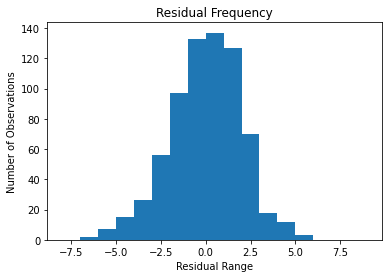

In [28]:
plt.hist(ubr_percent_error['Residual'],bins=r_bin_cutoffs)
plt.title("Residual Frequency")
plt.xlabel("Residual Range")
plt.ylabel("Number of Observations")

In [29]:
print("Maximum UBR residual: " + str(round(ubr_percent_error['Residual'].max(),4)))

Maximum UBR residual: 5.8273


In [30]:
print("Minimum UBR residual: " + str(round(ubr_percent_error['Residual'].min(),4)))

Minimum UBR residual: -8.0096


In [31]:
print("Mean UBR residual: " + str(round(ubr_percent_error['Residual'].mean(),4)))

Mean UBR residual: 0.0


In [32]:
ubr_percent_error = ubr_percent_error.reset_index()
ubr_percent_error = ubr_percent_error.drop(columns='index')
ubr_percent_error = ubr_percent_error.drop(columns='level_0')

KeyError: "['level_0'] not found in axis"

In [ ]:
residual_g1 = 0
residual_g2 = 0
residual_g3 = 0
residual_g4 = 0
residual_g5 = 0
residual_g6 = 0
residual_g7 = 0
residual_g8 = 0
for row in range(0,len(ubr_percent_error)):
    if (abs(ubr_percent_error['Residual'][row]) < 1):
        residual_g1 = residual_g1 + 1
    if (1 < abs(ubr_percent_error['Residual'][row]) < 2):
        residual_g2 = residual_g2 + 1
    if (2 < abs(ubr_percent_error['Residual'][row]) < 3):
        residual_g3 = residual_g3 + 1
    if (3 < abs(ubr_percent_error['Residual'][row]) < 4):
        residual_g4 = residual_g4 + 1
    if (4 < abs(ubr_percent_error['Residual'][row]) < 5):
        residual_g5 = residual_g5 + 1
    if (5 < abs(ubr_percent_error['Residual'][row]) < 6):
        residual_g6 = residual_g6 + 1
    if (6 < abs(ubr_percent_error['Residual'][row]) < 7):
        residual_g7 = residual_g7 + 1
    if (7 < abs(ubr_percent_error['Residual'][row])):
        residual_g8 = residual_g8 + 1

residual_g1_p = round((residual_g1/len(ubr_percent_error))*100,2)
print("Percent of observations with absolute value of residual less than 1: " + str(residual_g1_p))
residual_g2_p = round((residual_g2/len(ubr_percent_error))*100,2)
print("Percent of observations with absolute value of residual between 1 and 2: " + str(residual_g2_p))
residual_g3_p = round((residual_g3/len(ubr_percent_error))*100,2)
print("Percent of observations with absolute value of residual between 2 and 3: " + str(residual_g3_p))
residual_g4_p = round((residual_g4/len(ubr_percent_error))*100,2)
print("Percent of observations with absolute value of residual between 3 and 4: " + str(residual_g4_p))
residual_g5_p = round((residual_g5/len(ubr_percent_error))*100,2)
print("Percent of observations with absolute value of residual between 4 and 5: " + str(residual_g5_p))
residual_g6_p = round((residual_g6/len(ubr_percent_error))*100,2)
print("Percent of observations with absolute value of residual between 5 and 6: " + str(residual_g6_p))
residual_g7_p = round((residual_g7/len(ubr_percent_error))*100,2)
print("Percent of observations with absolute value of residual between 6 and 7: " + str(residual_g7_p))
residual_g8_p = round((residual_g8/len(ubr_percent_error))*100,2)
print("Percent of observations with absolute value of residual greater than 7: " + str(residual_g8_p))

We are not really satisfied with the accuracy of the UBR model overall. less than half of the residuals had absolute value less than 1, which is fairly poor. The UBR model seems to be much less accurate than the other models (OPS+, wRC+, xWOBA, sprint speed). Additionally, we chose to discard the information about the percent error of our model due to the fact that the error terms were just way too crazy. Some percent errors were in the thousands, and even though we had almost all centered at or around 0, these extreme outliers indicated that the analysis was just not valid for the units of UBR. 

Overall, we feel that the innacuracies of this model can be attributed to the fact that UBR was a fairly ambiguous and difficult metric to predict accurately with the data that we had.